In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime

In [ ]:
# for reference, because I never remember
# Creating a datetime object for December 1, 2015, at 22:08:00
# dt = datetime(2015, 12, 1, 22, 8, 0)

In [2]:
algae = pd.read_csv('habsos_20230714.csv', parse_dates=['SAMPLE_DATE'])

C:\Users\lowry\AppData\Local\Temp\ipykernel_24508\66257093.py:1: DtypeWarning: Columns (18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  algae = pd.read_csv('habsos_20230714.csv', parse_dates=['SAMPLE_DATE'])


In [128]:
algae_ven_sar = algae.loc[ (algae.LONGITUDE < -82.38)&(-82.7683 < algae.LONGITUDE )
              &( 26.96 < algae.LATITUDE )&( algae.LATITUDE <27.45 )]

In [5]:
#algae_ven_sar_dropna = algae_ven_sar.dropna(subset=['SALINITY','WATER_TEMP'], how='any').copy()

In [144]:
for i in range(1953,2024):
    print("num samples in " + str(i) + ": " + str(len(algae_ven_sar.loc[(algae_ven_sar.SAMPLE_DATE >= datetime(i,1,1)) & (algae_ven_sar.SAMPLE_DATE <= datetime(i+1,1,1))])))

num samples in 1953: 6
num samples in 1954: 141
num samples in 1955: 321
num samples in 1956: 364
num samples in 1957: 480
num samples in 1958: 326
num samples in 1959: 142
num samples in 1960: 0
num samples in 1961: 0
num samples in 1962: 0
num samples in 1963: 60
num samples in 1964: 203
num samples in 1965: 0
num samples in 1966: 46
num samples in 1967: 97
num samples in 1968: 26
num samples in 1969: 16
num samples in 1970: 0
num samples in 1971: 49
num samples in 1972: 4
num samples in 1973: 58
num samples in 1974: 198
num samples in 1975: 84
num samples in 1976: 204
num samples in 1977: 122
num samples in 1978: 164
num samples in 1979: 64
num samples in 1980: 154
num samples in 1981: 38
num samples in 1982: 72
num samples in 1983: 25
num samples in 1984: 24
num samples in 1985: 17
num samples in 1986: 40
num samples in 1987: 105
num samples in 1988: 29
num samples in 1989: 22
num samples in 1990: 28
num samples in 1991: 258
num samples in 1992: 247
num samples in 1993: 23
num samp

### A spike is defined to be any data point that exceeds the average cell count up to the date of collection

In [151]:
#look for a spike relative to that year for now
def spike(catalog,year1,year2):
    catalogyearspikes = []
    for i in range(year1,year2):
        pastreadings = catalog.loc[(catalog.SAMPLE_DATE < datetime(i,1,1))]['CELLCOUNT']
        peakmetric = pastreadings.mean()+1 #peak is defined as greater than the mean
        spikes = len(catalog.loc[(catalog.SAMPLE_DATE >= datetime(i,1,1)) 
                      & (catalog.SAMPLE_DATE < datetime(i+1,1,1))
                      & (catalog.CELLCOUNT>=peakmetric)]['CELLCOUNT'])

                
        catalogyearspikes.append(spikes)
    return catalogyearspikes

In [152]:
ven_sar_spikes = pd.DataFrame({'year': pd.date_range('1953', '2024', freq='Y'), 'num_spikes' : pd.Series(spike(algae_ven_sar, 1953, 2024))})

In [153]:
ven_sar_spikes

,year,num_spikes
0,1953-12-31,0
1,1954-12-31,0
2,1955-12-31,0
3,1956-12-31,0
4,1957-12-31,121
...,...,...
66,2019-12-31,48
67,2020-12-31,0
68,2021-12-31,108
69,2022-12-31,87


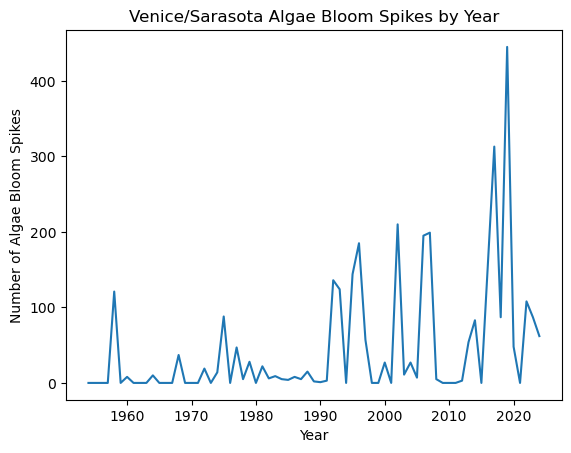

In [154]:
plt.plot(ven_sar_spikes.year, ven_sar_spikes.num_spikes)
plt.title('Venice/Sarasota Algae Bloom Spikes by Year')
plt.xlabel('Year')
plt.ylabel('Number of Algae Bloom Spikes')
plt.show()

In [73]:
alg_train =  ven_sar_spikes.loc[ven_sar_spikes.year < datetime(2023, 1, 1)].copy()
alg_test = ven_sar_spikes.drop(alg_train.index).copy()

## Average

In [67]:
train_avg = alg_train.num_spikes.mean()
train_avg

45.25714285714286

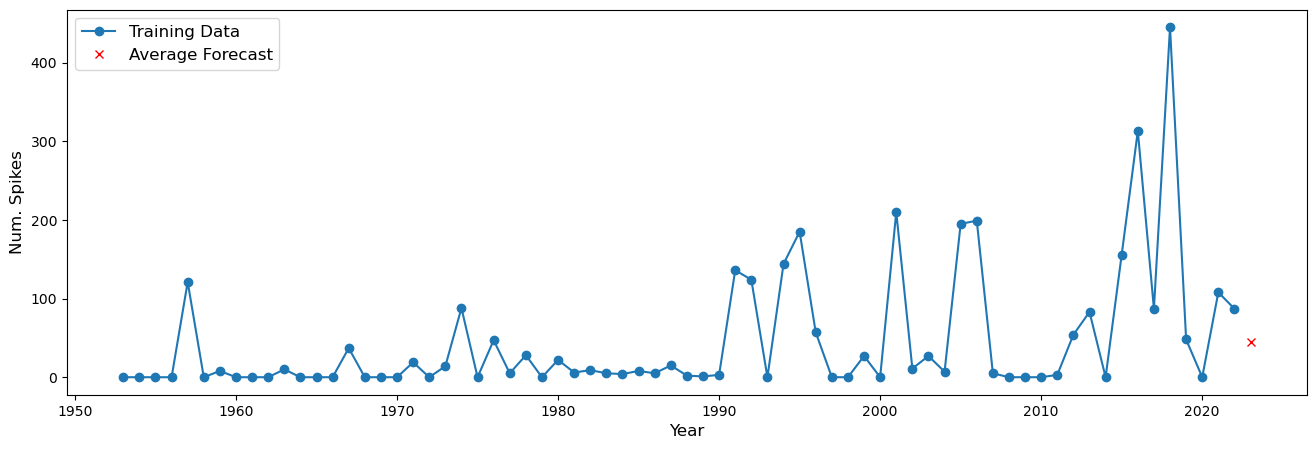

In [76]:
plt.figure(figsize=(16,5))

plt.plot([x.year for x in alg_train.year],
            alg_train.num_spikes,
            '-o',
            label = "Training Data")

plt.plot([2023], [train_avg], 'rx', label = 'Average Forecast') # 'rx' specifies a red x marker


plt.legend(fontsize=12)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Num. Spikes", fontsize=12)

    
plt.show()

## Naive

In [77]:
naive = alg_train.num_spikes.values[-1]

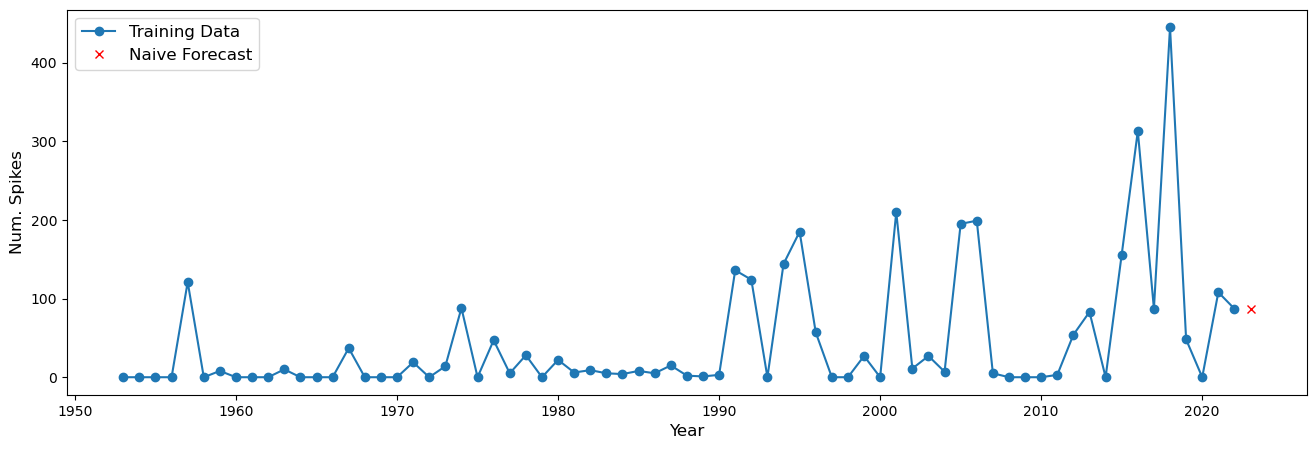

In [79]:
plt.figure(figsize=(16,5))

plt.plot([x.year for x in alg_train.year],
            alg_train.num_spikes,
            '-o',
            label = "Training Data")

plt.plot([2023], [naive], 'rx', label = 'Naive Forecast') # 'rx' specifies a red x marker


plt.legend(fontsize=12)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Num. Spikes", fontsize=12)

    
plt.show()

In [80]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [87]:
cv = TimeSeriesSplit(10, 
                     test_size=5)

In [103]:
avg_rmses = np.zeros(10)

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index] #train set
    alg_ho = alg_train.iloc[test_index] #holdout set
    
    tt_avg = alg_tt.num_spikes.mean()
    
    avg_rmses[i] = np.sqrt(mean_squared_error(alg_ho.num_spikes.values,
                                    tt_avg*np.ones(5)))
    
    i = i + 1

In [104]:
np.mean(avg_rmses)

78.02903131070202

In [97]:
naive_rmses = np.zeros(10)

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.loc[1953+train_index] #train set
    alg_ho = alg_train.loc[1953+test_index] #holdout set
    
    tt_naive = alg_tt.num_spikes.values[-1]
    
    naive_rmses[i] = np.sqrt(mean_squared_error(alg_ho.num_spikes.values,
                                    tt_naive*np.ones(5)))
    
    i = i + 1

In [98]:
np.mean(naive_rmses)

75.40741370470097

# models

In [99]:
# This function takes 3 numpy arrays as inputs.
# It returns the 
# mean absolute error of the forecast on the test set 
# relative to the
# mean absolute error of the naive forecast on the training set over an equivalent horizon.
# 
# If MASE > 1 then your forecast performs worse out of sample than naive forecast does in sample.
# If MASE < 1 then your forecast performs better out of sample than naive forecast does in sample.

def mase(y_train, y_test, y_preds):
    n = len(y_train)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom

## rolling average

In [100]:
cv = TimeSeriesSplit(10, test_size=5)

start = 2
end = 25
ra_mase = np.zeros((10, len(range(start, end))))


i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for q in range(start, end):
        pred = alg_tt.num_spikes[-q:].mean() * np.ones(len(alg_ho))
        
        ra_mase[i,j] = mase(alg_tt.num_spikes.values, alg_ho.num_spikes.values, pred)
        j = j + 1
    i = i + 1

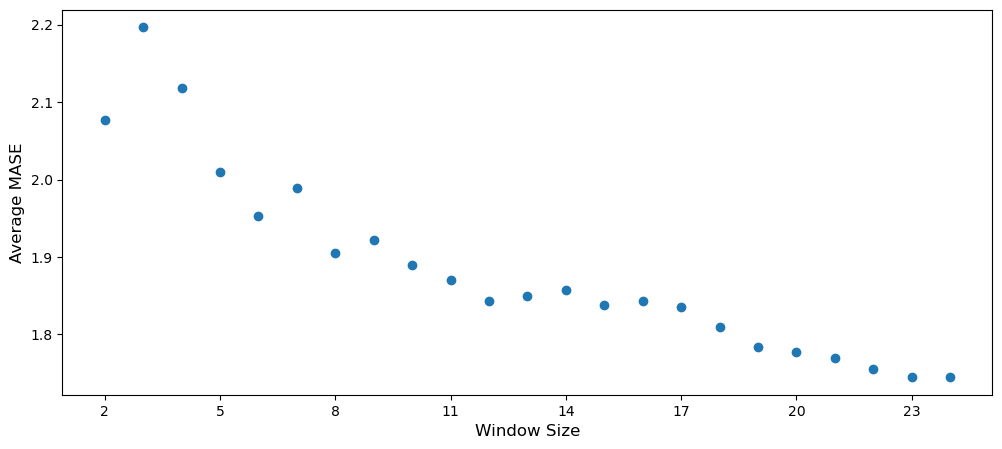

In [101]:
plt.figure(figsize=(12,5))

plt.scatter(range(start,end), np.mean(ra_mase, axis=0))

plt.xlabel("Window Size", fontsize=12)
plt.ylabel("Average MASE", fontsize=12)

plt.xticks(range(start, end, 3), fontsize=10)
plt.yticks(fontsize=10)

plt.show()

So this does not perform better than the naive model

## exponential smoothing

In [102]:
## Importing the model from statsmodels
from statsmodels.tsa.api import SimpleExpSmoothing

In [105]:
exp_mase = np.zeros((10, len(np.arange(0, 0.95, .01))))

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for alpha in np.arange(0, 0.95, .01):
        exp_smooth = SimpleExpSmoothing(alg_tt.num_spikes.values).fit(smoothing_level=alpha,optimized=False)
        exp_mase[i,j] = mase(alg_tt.num_spikes.values, alg_ho.num_spikes.values, exp_smooth.forecast(len(alg_ho)))
        j = j + 1
    i = i + 1

In [106]:
## This gives us the indices of the smallest
## avg cv rmse
exp_ind = np.argmin(np.mean(exp_mase, axis=0))

In [107]:
print("The alpha value that give simple exponential",
         "smoothing model with lowest avg cv rmse is",
         "alpha = ", np.arange(0, 0.95, .01)[exp_ind])

print("This model had an avg cv rmse of",
         np.round(np.mean(exp_mase, axis=0)[exp_ind],5))

The alpha value that give simple exponential smoothing model with lowest avg cv rmse is alpha =  0.9400000000000001
This model had an avg cv rmse of 1.69292


## ARIMA

In [108]:
import statsmodels.api as sm

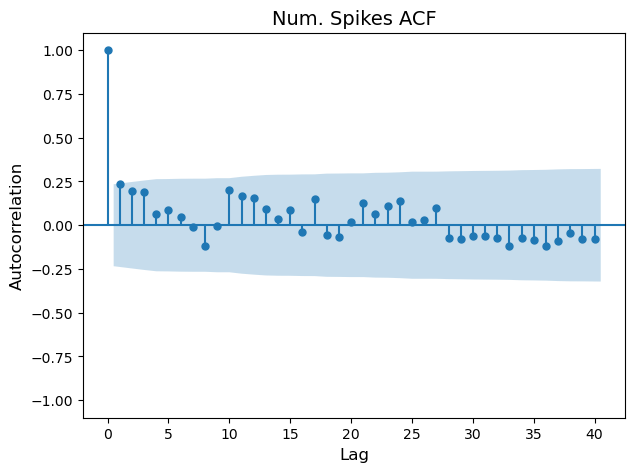

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

sm.graphics.tsa.plot_acf(alg_train.num_spikes,
                            lags = 40,
                            ax = ax)

plt.title('Num. Spikes ACF', fontsize=14)
plt.ylabel("Autocorrelation", fontsize=12)
plt.xlabel("Lag", fontsize=12)

plt.ylim(-1.1,1.1)

plt.show()

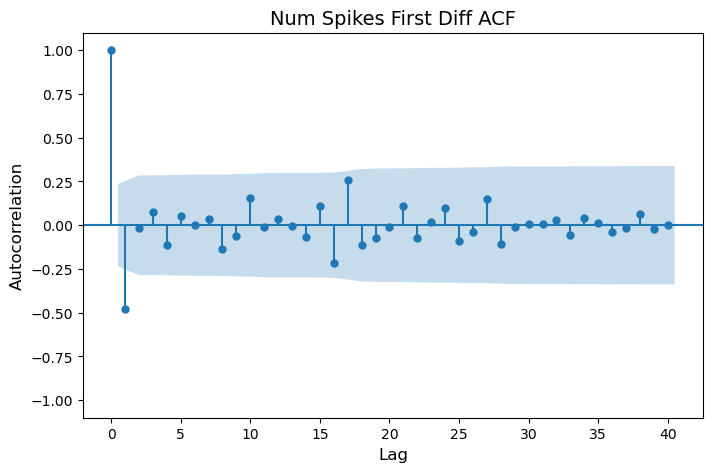

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

sm.graphics.tsa.plot_acf(alg_train.num_spikes.diff().values[1:],
                               lags=40,
                               ax=ax)

plt.title('Num Spikes First Diff ACF', fontsize=14)
plt.ylabel("Autocorrelation", fontsize=12)
plt.xlabel("Lag", fontsize=12)

plt.ylim(-1.1,1.1)

plt.show()

In [117]:
from statsmodels.tsa.api import ARIMA
from pmdarima import auto_arima

In [119]:
arima_mase = np.zeros((10, 4, 4))

i = 0
for train_index, test_index in cv.split(alg_train):

    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for p in range(4):
        k = 0
        for q in range(4):
            arima = ARIMA(alg_tt.num_spikes.values,
                               order=(p, 1, q)).fit()
            
            arima_mase[i,j,k] = mase(alg_tt.num_spikes.values, alg_ho.num_spikes.values,  arima.forecast(len(alg_ho)))
            k = k +1
        j = j + 1
    i = i +1

C:\Users\lowry\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\lowry\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\lowry\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\lowry\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\lowry\anaconda3\Lib\site-packages\statsmodels\base\model

In [120]:
arima_ind = np.unravel_index(np.argmin(np.mean(arima_mase, axis=0), axis=None), 
                             np.mean(arima_mase, axis=0).shape)
np.unravel_index(np.argmin(np.mean(arima_mase, axis=0), axis=None), 
                 np.mean(arima_mase, axis=0).shape)

(0, 0)

In [121]:
print("The parameters that give an ARIMA model",
         "with lowest avg cv mase are",
         "(p,d,q) = ( %s, %s, %s )" %(range(4)[arima_ind[0]], 1, range(4)[arima_ind[1]]))

print("This model had an avg cv mase of",
         np.round(np.mean(arima_mase, axis=0)[arima_ind],3))

The parameters that give an ARIMA model with lowest avg cv mase are (p,d,q) = ( 0, 1, 0 )
This model had an avg cv mase of 1.683


In [123]:
auto_arima(alg_train.num_spikes.values, trace=True, max_p=8, max_q=8)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=836.064, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=820.485, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=834.074, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=815.355, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=816.371, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=813.405, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=818.520, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=814.429, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=805.912, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=804.121, Time=0.04 sec
 A

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [125]:
arima_mase_auto = np.zeros((10))

i = 0
for train_index, test_index in cv.split(alg_train):

    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    arima = ARIMA(alg_tt.num_spikes.values,
                               order=(1, 1, 1)).fit()
    arima_mase_auto[i] = mase(alg_tt.num_spikes.values, alg_ho.num_spikes.values,  arima.forecast(len(alg_ho)))
            
    i = i +1

C:\Users\lowry\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [126]:
arima_mase_auto.mean()

1.831368702709484